In [41]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from utils import set_seed, load_model, save_model, _model_file
from torchvision import transforms
from torchvision.datasets import FashionMNIST

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")
sns.set_theme()

# Setup Environment

In [42]:
# Set paths to store dataset and pretrained models
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/fashion_mnist")
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "models/fashion_mnist")

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [43]:
# Function for setting the seed from utils.py
set_seed(123)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [44]:
# Set device for used throughout this notebook
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [45]:
import urllib
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# Files to download
pretrained_files = [
    "FashionMNIST_elu.config",
    "FashionMNIST_elu.tar",
    "FashionMNIST_leakyrelu.config",
    "FashionMNIST_leakyrelu.tar",
    "FashionMNIST_relu.config",
    "FashionMNIST_relu.tar",
    "FashionMNIST_sigmoid.config",
    "FashionMNIST_sigmoid.tar",
    "FashionMNIST_swish.config",
    "FashionMNIST_swish.tar",
    "FashionMNIST_tanh.config",
    "FashionMNIST_tanh.tar",
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

# Activation functions

### Defining some activation functions

In [46]:
# Base class for all activation functions
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

In [47]:
class Sigmoid(ActivationFunction):
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

In [48]:
class Tanh(ActivationFunction):
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

In [49]:
class ReLU(ActivationFunction):
    def forward(self, x):
        return x * (x > 0).float()

In [50]:
class LeakyReLU(ActivationFunction):
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

In [51]:
class ELU(ActivationFunction):
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)

In [52]:
class Swish(ActivationFunction):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [53]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

### Visualizing activation functions

In [54]:
def get_grads(act_fn, x):
    x = x.clone().requires_grad_()
    out = act_fn(x)
    out.sum().backward()
    return x.grad

In [55]:
def vis_act_fn(act_fn, ax, x):
    def numpy(x):
        return x.cpu().numpy()

    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    
    # push vars into cpu for plotting
    x, y, y_grads = numpy(x), numpy(y), numpy(y_grads)
    
    # plotting
    ax.plot(x, y, linewidth=2, label="Act_Fn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

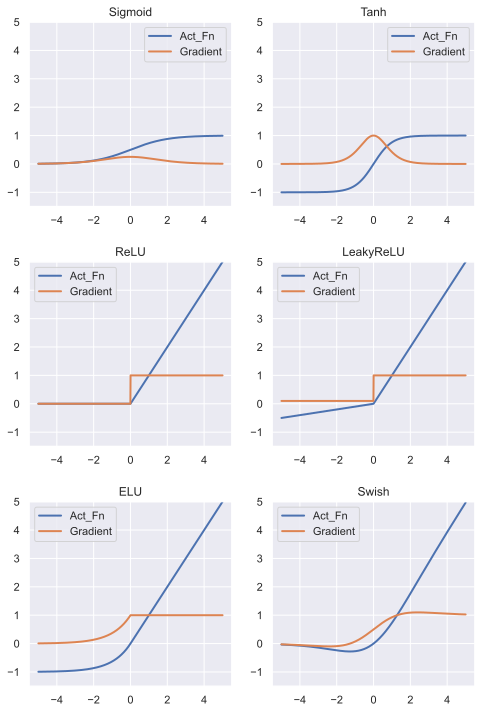

In [56]:
x = torch.linspace(-5, 5, 1000)
cols = 2
rows = int(np.ceil(len(act_fn_by_name) / float(cols)))
fig, ax = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
for i, act_fn_class in enumerate(act_fn_by_name.values()):
    vis_act_fn(act_fn_class(), ax[divmod(i, cols)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

# Download Dataset

In [57]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = FashionMNIST(root=DATASET_PATH,
                             train=True,
                             transform=transform,
                             download=True)

train_set, val_set = torch.utils.data.random_split(train_dataset, [50_000, 10_000])
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

In [58]:
train_loader = data.DataLoader(train_set,
                               batch_size=1024,
                               shuffle=True,
                               drop_last=False)

val_loader = data.DataLoader(val_set,
                             batch_size=1024,
                             shuffle=True,
                             drop_last=False)

test_loader = data.DataLoader(test_set,
                              batch_size=1024,
                              shuffle=False,
                              drop_last=False)

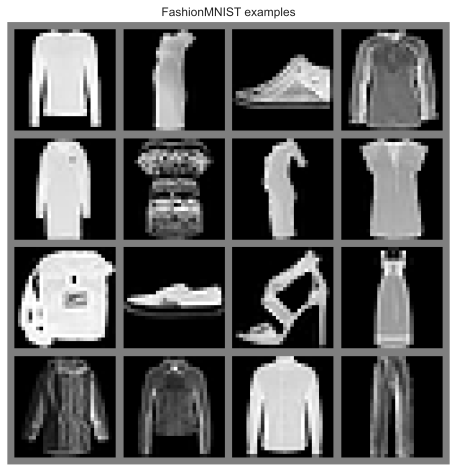

In [59]:
exmp_imgs = [train_set[i][0] for i in range(16)]
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0),
                                       nrow=4,
                                       normalize=True,
                                       pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

# Building Model

### Setup base network

In [60]:
class BaseNetwork(nn.Module):
    def __init__(self,
                 act_fn,
                 model_name = "",
                 train_scores = None,
                 val_scores = None,
                 num_classes=10,
                 input_size=784,
                 hidden_sizes=[256, 128, 128, 64]):
        super().__init__()

        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for i in range(len(layer_sizes)-1):
            layers += [nn.Linear(layer_sizes[i], layer_sizes[i+1]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers)

        self.config = {
            "act_fn": act_fn.config,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
            "model_name": model_name,
            "train_scores": train_scores,
            "val_scores": val_scores
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.layers(x)
        return out

### Comparing gradients magnitude

In [61]:
def get_grads(net):   
    net.eval()
    net.zero_grad()

    imgs, labels = next(iter(train_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    preds = net(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()

    grads = {}
    for name, params in net.named_parameters():
        if "weight" not in name: 
            continue
        grads[name] = params.grad.data.view(-1).cpu().clone().numpy()

    net.zero_grad()
    return grads

In [62]:
def plot_grads(net, grads, color="C0"):
    cols = len(grads)
    fig, ax = plt.subplots(1, cols, figsize=(cols*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index % cols]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=f"C{i}", kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad Magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient Magnitude Distribution: {net.config['act_fn']['name']}",
                 fontsize=12,
                 y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

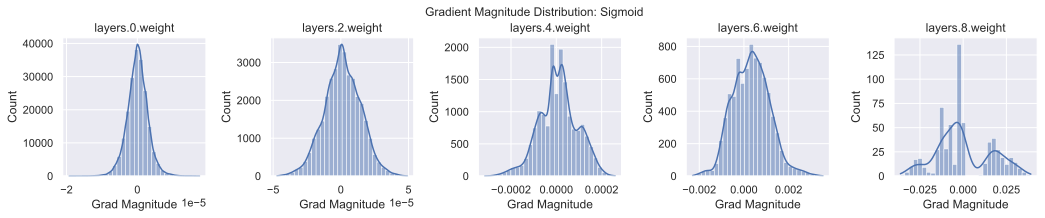

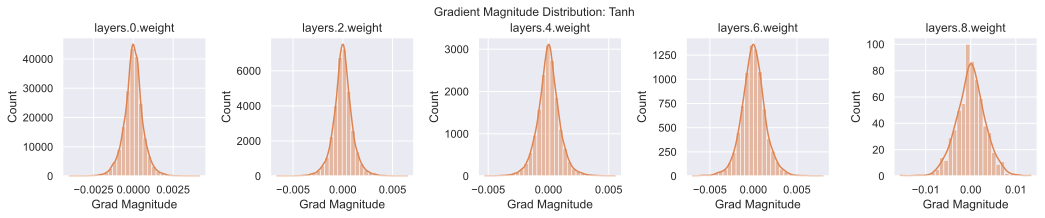

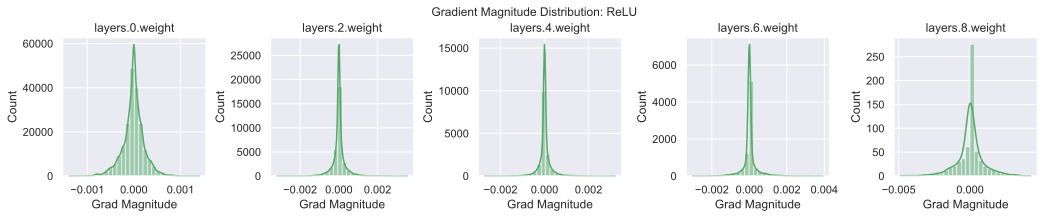

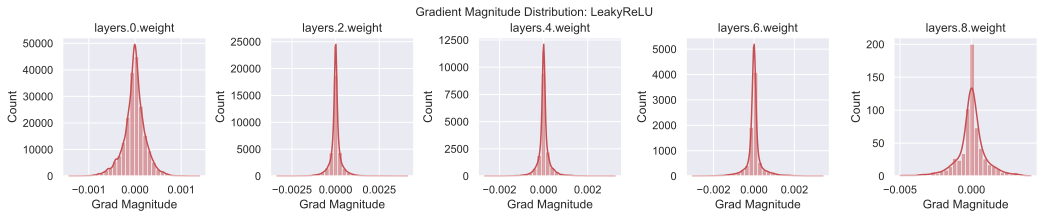

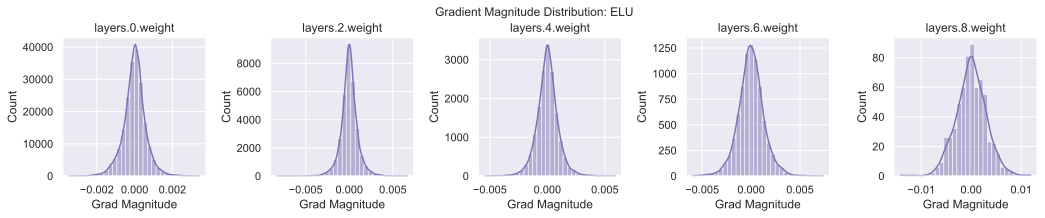

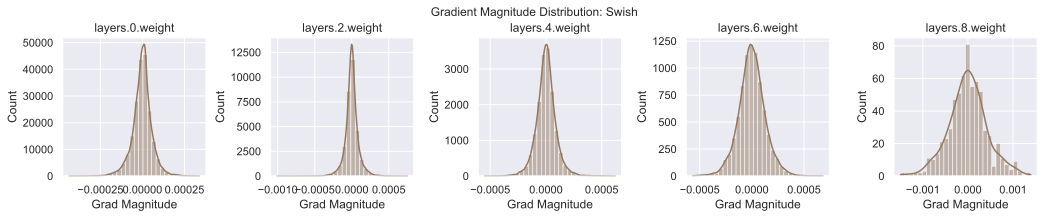

In [63]:
for i, (act_fn_name, act_fn_class) in enumerate(act_fn_by_name.items()):
    set_seed(36)
    net = BaseNetwork(act_fn=act_fn_class()).to(device)
    grads = get_grads(net)
    plot_grads(net, grads)

### Training models

In [64]:
def train_model(net,
                model_name,
                train_loader,
                val_loader,
                epochs=30,
                patience=7,
                overwrite=False):
    file_exists = os.path.isfile(_model_file(CHECKPOINT_PATH, model_name))

    if file_exists and not overwrite:
        print(f"Model file {model_name} already exists. Skip training.")
        net = load_model(CHECKPOINT_PATH, model_name, act_fn_by_name, BaseNetwork, net = None)
    else:
        if file_exists:
            print(f"Model file {model_name} exists, but will be overwritten")
        else:
            print(f"Model file {model_name} not exists. Start training...")

        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9)
        loss_module = nn.CrossEntropyLoss()
        train_scores = []
        val_scores = []
        best_val_epoch = -1

        net = net.to(device)
        for epoch in range(1, 1+epochs):

            net.train()
            true_preds, count = 0.0, 0
            for X, y in train_loader:
                X = X.to(device)
                y = y.to(device)
                preds = net(X)
                loss = loss_module(preds, y)
                optimizer.zero_grad()                
                loss.backward()
                optimizer.step()
                true_preds += (preds.argmax(dim=-1) == y).sum()
                count += y.shape[0]
            train_acc = true_preds / count
            train_scores.append(train_acc.cpu().clone().numpy().item())

            net.eval()
            true_preds, count = 0.0, 0
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)
                with torch.no_grad():
                    preds = net(X)
                true_preds += (preds.argmax(dim=-1) == y).sum()
                count += y.shape[0]
            val_acc = true_preds / count
            val_scores.append(val_acc.cpu().clone().numpy().item())

            if len(val_scores) <= 1 or val_acc > val_scores[best_val_epoch]:
                best_val_epoch = epoch
                net.config["train_scores"] = train_scores
                net.config["val_scores"] = val_scores
                net.config["model_name"] = model_name
                save_model(net, CHECKPOINT_PATH, model_name)
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping at {epoch} epochs")
                break

    return net

In [65]:
def test_model(net, data_loader):
    net.eval()
    net = net.to(device)
    true_preds, count = 0.0, 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [66]:
def plot_training(net):
    model_name = net.config["model_name"]
    train_scores = net.config["train_scores"]
    val_scores = net.config["val_scores"]

    # Plot the data
    plt.figure(figsize=(5, 3))  # width: 10 inches, height: 6 inches
    plt.plot([i for i in range(1, len(train_scores) + 1)], train_scores, color="blue", label="Train")
    plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Training and Validation accuracy of {model_name}")
    plt.legend() 
    plt.show()
    plt.close()

### Model training using different activation functions

Model file FashionMNIST-sigmoid already exists. Skip training.
Test Accuracy: 0.1


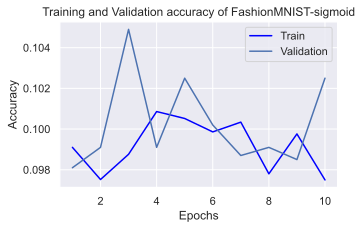

Model file FashionMNIST-tanh already exists. Skip training.
Test Accuracy: 0.8768


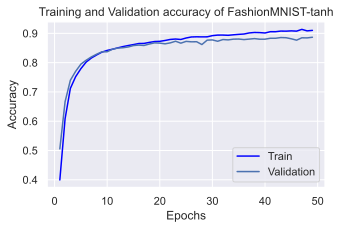

Model file FashionMNIST-relu already exists. Skip training.
Test Accuracy: 0.8809


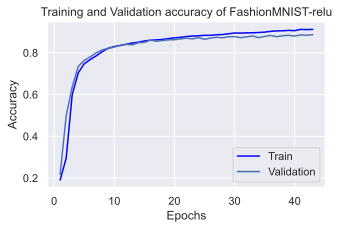

Model file FashionMNIST-leakyrelu already exists. Skip training.
Test Accuracy: 0.8752


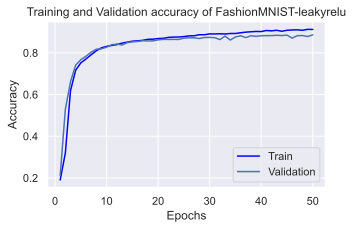

Model file FashionMNIST-elu already exists. Skip training.
Test Accuracy: 0.8704


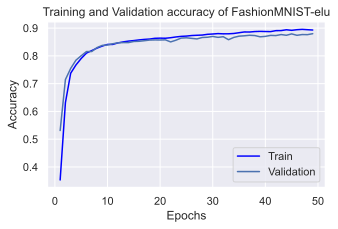

Model file FashionMNIST-swish already exists. Skip training.
Test Accuracy: 0.866


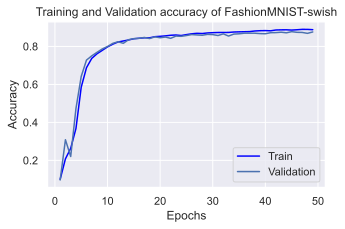

In [67]:
models = {}
for act_fn_name, act_fn_class in act_fn_by_name.items():
    set_seed(32)
    net = BaseNetwork(act_fn_class()).to(device)
    net = train_model(net,
                      f"FashionMNIST-{act_fn_name}",
                      train_loader,
                      val_loader,
                      epochs=50,
                      overwrite=False)
      
    print(f"Test Accuracy: {test_model(net, test_loader)}")
    plot_training(net)

### Examine dead neurons

In [68]:
def measure_number_dead_neurons(net):
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool)
        for layer in net.layers[:-1]
        if isinstance(layer, nn.Linear)
    ]

    net.eval()
    net.to(device)

    with torch.no_grad():
        
        for imgs, _ in train_loader:
            index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    neurons_dead[index] = torch.logical_and(neurons_dead[index],
                                                            (imgs == 0).all(dim=0))
                    index+=1
    
    return neurons_dead

In [69]:
def print_neurons_dead(neurons_dead):
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("  Number of dead neurons:", ", ".join([str(n) for n in number_neurons_dead]))
    print(
        "  In percentage:",
        ", ".join(
            [f"{(100.0 * num_dead / tens.shape[0]):4.2f}%"
             for tens, num_dead in zip(neurons_dead, number_neurons_dead)]
        ),
    )
    print()

In [70]:
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
neurons_dead = measure_number_dead_neurons(net_relu)
print_neurons_dead(neurons_dead)

  Number of dead neurons: 0, 0, 3, 9
  In percentage: 0.00%, 0.00%, 2.34%, 14.06%



In [71]:
net_relu = BaseNetwork(
    act_fn=ReLU(),
    hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128],
).to(device)
neurons_dead = measure_number_dead_neurons(net_relu)
print_neurons_dead(neurons_dead)

  Number of dead neurons: 0, 0, 4, 25, 70, 56, 64, 59, 61, 59
  In percentage: 0.00%, 0.00%, 1.56%, 9.77%, 27.34%, 43.75%, 50.00%, 46.09%, 47.66%, 46.09%



In [72]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net = BaseNetwork(act_fn_class()).to(device)
    net = load_model(CHECKPOINT_PATH, f"FashionMNIST-{act_fn_name}", act_fn_by_name, BaseNetwork)
    
    neurons_dead = measure_number_dead_neurons(net)
    
    print(f"Check dead neurons for FashionMNIST-{act_fn_name}")
    print_neurons_dead(neurons_dead)

Check dead neurons for FashionMNIST-sigmoid
  Number of dead neurons: 0, 0, 0, 0
  In percentage: 0.00%, 0.00%, 0.00%, 0.00%

Check dead neurons for FashionMNIST-tanh
  Number of dead neurons: 0, 0, 0, 0
  In percentage: 0.00%, 0.00%, 0.00%, 0.00%

Check dead neurons for FashionMNIST-relu
  Number of dead neurons: 0, 0, 3, 4
  In percentage: 0.00%, 0.00%, 2.34%, 6.25%

Check dead neurons for FashionMNIST-leakyrelu
  Number of dead neurons: 0, 0, 0, 0
  In percentage: 0.00%, 0.00%, 0.00%, 0.00%

Check dead neurons for FashionMNIST-elu
  Number of dead neurons: 0, 0, 0, 0
  In percentage: 0.00%, 0.00%, 0.00%, 0.00%

Check dead neurons for FashionMNIST-swish
  Number of dead neurons: 0, 0, 0, 0
  In percentage: 0.00%, 0.00%, 0.00%, 0.00%



In [73]:
def visualize_activations(net, color="C0"):
    activations = {}

    net.eval()
    net.to(device)
    imgs, _ = next(iter(train_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    # Plotting
    columns = 4
    rows = int(np.ceil(len(activations) / columns))
    fig, ax = plt.subplots(rows, columns, figsize=(columns * 2.7, rows * 2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index // columns][fig_index % columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()


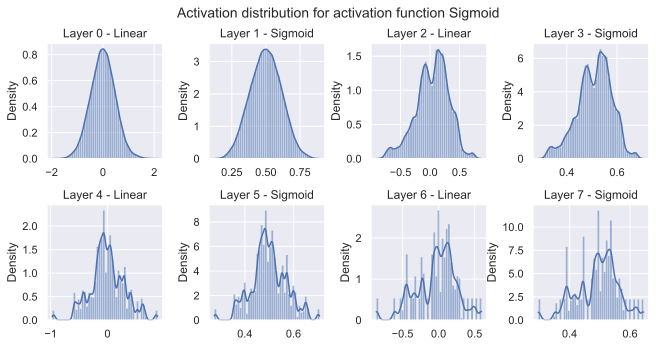

Test Accuracy: 0.1



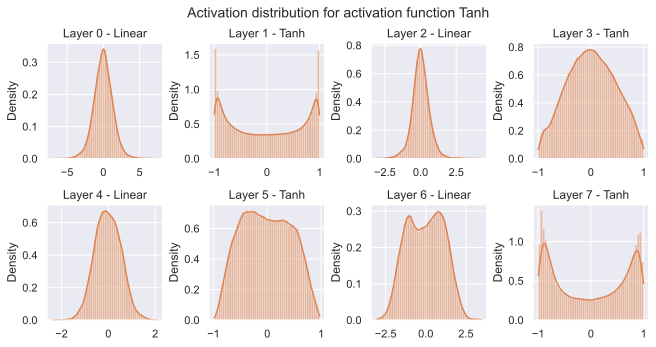

Test Accuracy: 0.8768



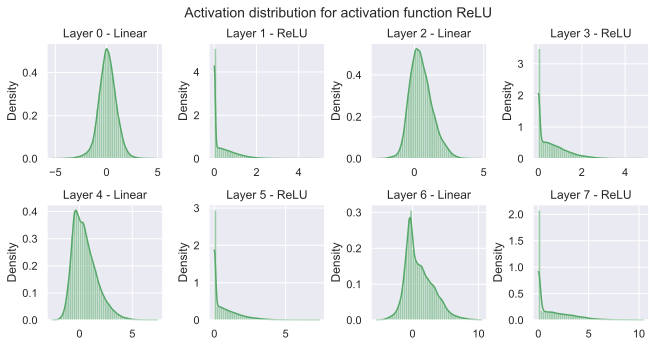

Test Accuracy: 0.8809



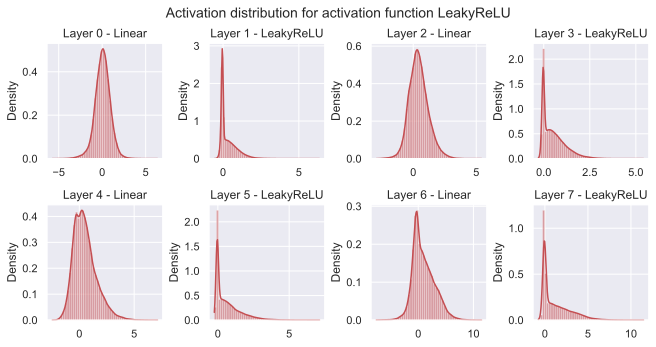

Test Accuracy: 0.8752



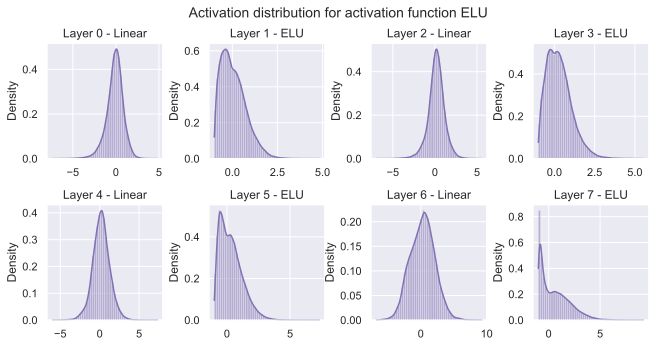

Test Accuracy: 0.8704



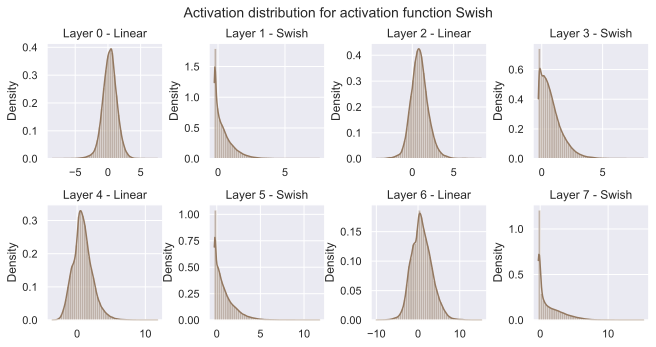

Test Accuracy: 0.866



In [74]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net = BaseNetwork(act_fn_class()).to(device)
    net = load_model(CHECKPOINT_PATH, f"FashionMNIST-{act_fn_name}", act_fn_by_name, BaseNetwork)
    visualize_activations(net, color=f"C{i}")
    print(f"Test Accuracy: {test_model(net, test_loader)}\n")